Link to our folder: https://drive.google.com/drive/folders/1SQgndwhZpgW1fzgLWF8Sih_s6UoPFlDB?usp=sharing

<b><h1>HOMEWORK 1 🍃</h1></b>

> In this homework we are asked to classify plants (like the ones in the example image below) that are divided into two categories according to their state of health. It is a binary classification problem, so the goal is to predict the correct class label in {0, 1}.

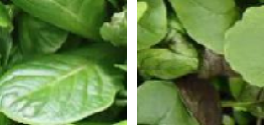

## 👨‍👨‍👧‍👦 Our team group - ANN
- ```Balestrieri Niccolò - 10936955```
- ```Bertogalli Andrea - 10702303```
- ```Tombini Nicolò - 10912627```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import os.path
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
import cv2
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import seaborn as sns
import itertools
from numpy.ma.core import mean
from pandas._libs.tslibs.offsets import roll_qtrday
import tensorflow.keras as tfk
from numpy.ma.core import mean
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers.experimental import preprocessing
!pip install keras-tuner
from kerastuner.tuners import BayesianOptimization
import keras_tuner as kt

balanced = True
seed = 42
random.seed(seed)
np.random.seed(seed)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

## 🔎 Dataset Load and outliers detection

In this section of the notebook, all operations related to the import and processing of images are managed. Specifically, after reading the dataset in NPZ format, we inspected it and then, outliers and duplicates are removed.
In particular, after the dataset has been cleaned, the data is divided into training and validation sets with a specific consideration: two datasets are created. The first one has imbalanced training and validation sets, while the second one has imbalanced training but balanced validation.

In [ ]:
# Import the dataset
data = np.load("/content/drive/My Drive/Homework1/public_data.npz", allow_pickle=True)
images, labels = data['data'], data['labels']

# Import treats examples
treats = np.load("/content/drive/My Drive/Homework1/data/treats.npz")['treats']

# Inspect dataset
def inspect_dataset():
  num_img = 10
  fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
  for i in range(num_img):
    rnd_img = random.randint(0, 5200)
    ax = axes[i % num_img]
    ax.imshow(images[rnd_img].astype("uint8"))
    ax.set_title(f'{labels[rnd_img]}')

  plt.tight_layout()
  plt.show()

inspect_dataset()

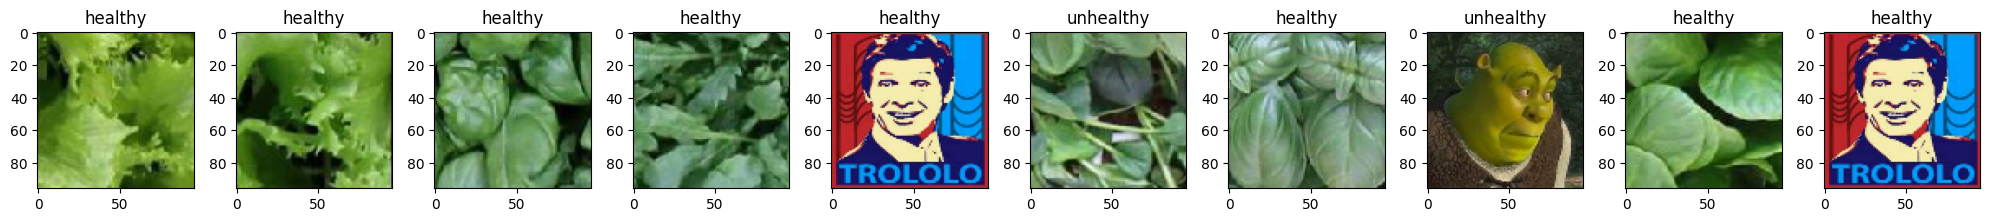

In [ ]:
# Class_perc represents the amount of samples for one class, so 0.1 is equivalen to a 20% split on validation set
def split_balanced_validation(X, y, class_perc=0.1):
    X_train, y_train, X_val, y_val = [], [], [], []

    # Count the occurrences of 'healthy' and 'unhealthy' labels in the target variable
    healthy, unhealthy = np.unique(y, return_counts=True)[1][0], np.unique(y, return_counts=True)[1][1]

    # Calculate the length of the validation set based on the specified percentage
    val_len = len(y) * class_perc

    # Calculate the length of the training set
    train_len = (healthy + unhealthy) - val_len

    # Ensure the validation set length is even for balanced splitting
    balanced_len = int(val_len if not val_len % 2 else val_len - 1)

    # Get indices of 'healthy' and 'unhealthy' instances
    h_indices = np.where(y == 'healthy')[0]
    u_indices = np.where(y == 'unhealthy')[0]

    # Create the balanced validation set by combining 'healthy' and 'unhealthy' samples
    X_val = np.concatenate((X[h_indices[:balanced_len]], X[u_indices[:balanced_len]]))
    y_val = np.concatenate((y[h_indices[:balanced_len]], y[u_indices[:balanced_len]]))

    # Create the training set with the remaining samples
    X_train = np.concatenate((X[h_indices[balanced_len:]], X[u_indices[balanced_len:]]))
    y_train = np.concatenate((y[h_indices[balanced_len:]], y[u_indices[balanced_len:]]))

    # Shuffle the training and validation sets
    X_train, y_train = shuffle(X_train, y_train)
    X_val, y_val = shuffle(X_val, y_val)

    return X_train, y_train, X_val, y_val

In [ ]:
def sanitize_and_remove_duplicates(treats, images, labels):
    sanitized_dataset = []
    sanitized_labels = []

    # Iterate through images to remove specific treats (shrek, trolls)
    for index, img in enumerate(images):
        flag = True
        for t in treats:
            if np.all(img == t):
                flag = False
        if flag:
            sanitized_dataset.append(img)
            sanitized_labels.append(labels[index])

    # Identify and remove duplicate entries in the sanitized dataset
    duplicate_list = []
    for i in range(len(sanitized_dataset)):
        for j in range(i+1, len(sanitized_dataset)):
            if np.all(sanitized_dataset[i] == sanitized_dataset[j]):
                duplicate_list.append(j)

    # Delete duplicate entries from the sanitized dataset and labels
    sanitized_dataset = np.delete(np.array(sanitized_dataset), duplicate_list, axis=0)
    sanitized_labels = np.delete(np.array(sanitized_labels), duplicate_list)

    return sanitized_dataset, sanitized_labels

In [ ]:
sanitized_dataset, sanitized_labels = sanitize_and_remove_duplicates(treats, images, labels)

np.savez("/content/drive/My Drive/Homework1/data/cleaned_data.npz", images=sanitized_dataset, labels=sanitized_labels)

In [ ]:
# Loading data
X_train, y_train, X_val, y_val = [], [], [], []

# If it is the first time, let's split train and validation (balanced)
if not os.path.isfile("/content/drive/My Drive/Homework1/data/balance_dataset.npz") or not os.path.isfile("/content/drive/My Drive/Homework1/data/imbalance_dataset.npz"):
  data = np.load("/content/drive/My Drive/Homework1/data/cleaned_data.npz", allow_pickle=True)
  images, labels = data['images'], data['labels']
  X_train, y_train, X_val, y_val  = split_balanced_validation(images, labels)
  X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(images, labels, test_size=0.1, stratify=labels)
  np.savez("/content/drive/My Drive/Homework1/data/imbalance_dataset.npz", X_train_imb=X_train_imb, y_train_imb=y_train_imb, X_val_imb=X_val_imb, y_val_imb=y_val_imb)
  np.savez("/content/drive/My Drive/Homework1/data/balance_dataset.npz", X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
else:
  if balanced:
    data = np.load("/content/drive/My Drive/Homework1/data/balance_dataset.npz", allow_pickle=True)
    X_train, y_train, X_val, y_val  = data['X_train'], data['y_train'], data['X_val'], data['y_val']
  else:
    data = np.load("/content/drive/My Drive/Homework1/data/imbalance_dataset.npz", allow_pickle=True)
    X_train, y_train, X_val, y_val  = data['X_train_imb'], data['y_train_imb'], data['X_val_imb'], data['y_val_imb']

## 👀 Depth inspections

In this section, a thorough analysis of the dataset is presented to understand how the data (in this case, images) are arranged in a two-dimensional space, aiming to determine if there is any intrinsic structure to them.

Initially, image embeddings were generated from the ConvNeXtXLarge network. Subsequently, a clustering algorithm (KMeans, with k = 2 corresponding to healthy or unhealthy) was performed to cluster similar images. Finally, the t-SNE algorithm was employed to visualize the clusters in 2D. The obtained visual result suggests that the types of leaves (healthy or unhealthy) are all close to each other, indicating well-labeled data. What is not entirely clear is the distance between unhealthy and healthy leaves, which, however, proves to be quite reasonable. Indeed, the images in question have a dimension of 96x96x3 = 27648, and plotting them in 2D leads to a significant loss of information.

In [ ]:
# Define ConvNeXtXLarge model for feature extraction
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True
)
fem.trainable = False

# Initialize an empty DataFrame to store image embeddings
embeddings = pd.DataFrame(columns=list(range(2048)))

# Iterate over images to generate embeddings using the pre-trained model
for img in images:
    embedding = fem.predict(img.reshape(1, 96, 96, 3)).reshape(-1)
    embeddings = embeddings.append(pd.Series(embedding, index=embeddings.columns), ignore_index=True)

# Display the first few rows of the embeddings DataFrame and its shape
print(embeddings.head())
print(embeddings.shape)

embeddings.to_csv('/content/drive/My Drive/Homework1/data/embeddings_ConvNeXtXLarge.csv', index=False)
embeddings = pd.read_csv("/content/drive/My Drive/Homework1/data/embeddings_ConvNeXtXLarge.csv")

# Apply KMeans clustering with 2 clusters, healthy or unhealthy
k_means = KMeans(2)
clusters = k_means.fit_predict(embeddings)

# Perform t-SNE dimensionality reduction for visualization in 2D
tsne_model_en_2d = TSNE(n_components=2, init='pca')
low_dim_embeddings = tsne_model_en_2d.fit_transform(embeddings)

# Count the number of instances for each cluster and ground truth label
count = 0
f_labels = np.where(labels == "healthy", 0, 1)

h_cnt_0, u_cnt_0, h_cnt_1, u_cnt_1 = 0, 0, 0, 0

for c in range(len(clusters)):
    if(clusters[c] == 0 and f_labels[c] == 0):
        h_cnt_0 += 1
    elif(clusters[c] == 0 and f_labels[c] == 1):
        u_cnt_0 += 1
    elif(clusters[c] == 1 and f_labels[c] == 0):
        h_cnt_1 += 1
    elif(clusters[c] == 1 and f_labels[c] == 1):
        u_cnt_1 += 1

# Display the count of instances for each cluster and label
print((h_cnt_0, u_cnt_0))
print((h_cnt_1, u_cnt_1))

# Separate low-dimensional embeddings for healthy and unhealthy instances
healthy_pts = [low_dim_embeddings[i] for i in range(len(low_dim_embeddings)) if labels[i] == 'healthy']
unhealthy_pts = [low_dim_embeddings[i] for i in range(len(low_dim_embeddings)) if labels[i] == 'unhealthy']

# Extract x and y coordinates for healthy and unhealthy points
x_h, y_h = zip(*healthy_pts)
x_u, y_u = zip(*unhealthy_pts)

# Visualize clusters
plt.scatter(x_h, y_h, c='green', label='Healthy')
plt.scatter(x_u, y_u, c='red', label='Unhealthy')
plt.legend()
plt.show()


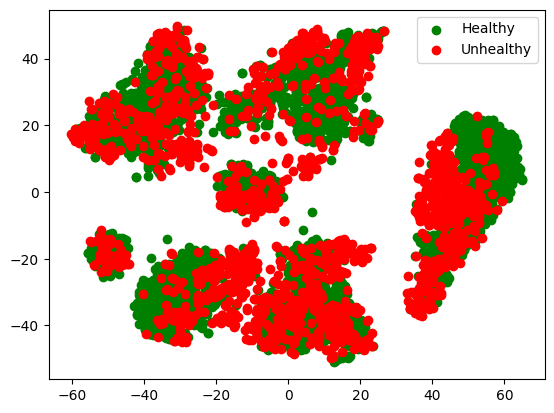

## 📊 Fem comparison and Fem selection

In this section of the notebook, the entire topic of model selection is addressed. Specifically, various pre-trained networks with default configurations were employed to assess which one performed better, with an eye towards future analyses.
All these networks have only a softmax at the end of the architecture.


In [ ]:
def encoding_labels(y_train, y_val):
    if(len(list(y_train.shape)) > 1):
      return y_train, y_val

    # Convert class labels to binary (0 or 1)
    y_train = np.where(y_train == "healthy", 0, 1)
    y_val = np.where(y_val == "healthy", 0, 1)

    # Convert binary labels to one-hot encoding
    y_train = tfk.utils.to_categorical(y_train)
    y_val = tfk.utils.to_categorical(y_val)

    print(y_train.shape)
    print(y_val.shape)

    return y_train, y_val

def eval_model(X_val, y_val, history, model):
    # Infer class labels for the validation set
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate evaluation metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-score:", f1)

    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='train_loss', alpha=.8, color='#000000')
    plt.plot(history['val_loss'], label='val_loss', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    # Plot training and validation accuracy
    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='train_accuracy', alpha=.8, color='#000000')
    plt.plot(history['val_accuracy'], label='val_accuracy', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

def plot_histories(history):
    # Plot training and validation loss
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='train_loss', alpha=.8, color='#000000')
    plt.plot(history['val_loss'], label='val_loss', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    # Plot training and validation accuracy
    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='train_loss', alpha=.8, color='#000000')
    plt.plot(history['val_accuracy'], label='val_accuracy', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

def model_save(model, path):
    # Save the trained model to the specified path
    model.save(path)


### ResNet50
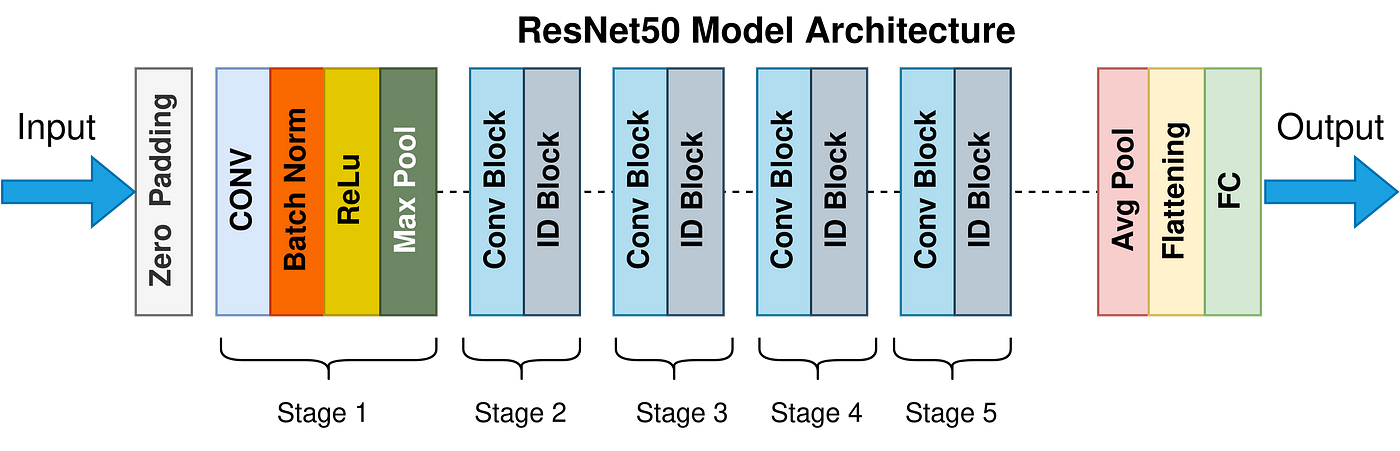

In [ ]:
def pad_images(images, target_size):
  padded_images = []
  for i in images:
    padded_images.append(tf.image.resize(i, target_size, tf.image.ResizeMethod.BILINEAR, True))

  padded_images = np.array(padded_images)
  return padded_images

fem = tfk.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(fem, show_shapes=True)

fem.trainable = False
inputs = tfk.Input(shape=(224, 224, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

padded_train = pad_images(X_train, (224, 224))
padded_val = pad_images(X_val, (224, 224))

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = preprocess_input(padded_train),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(padded_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

### EfficientNetV2L

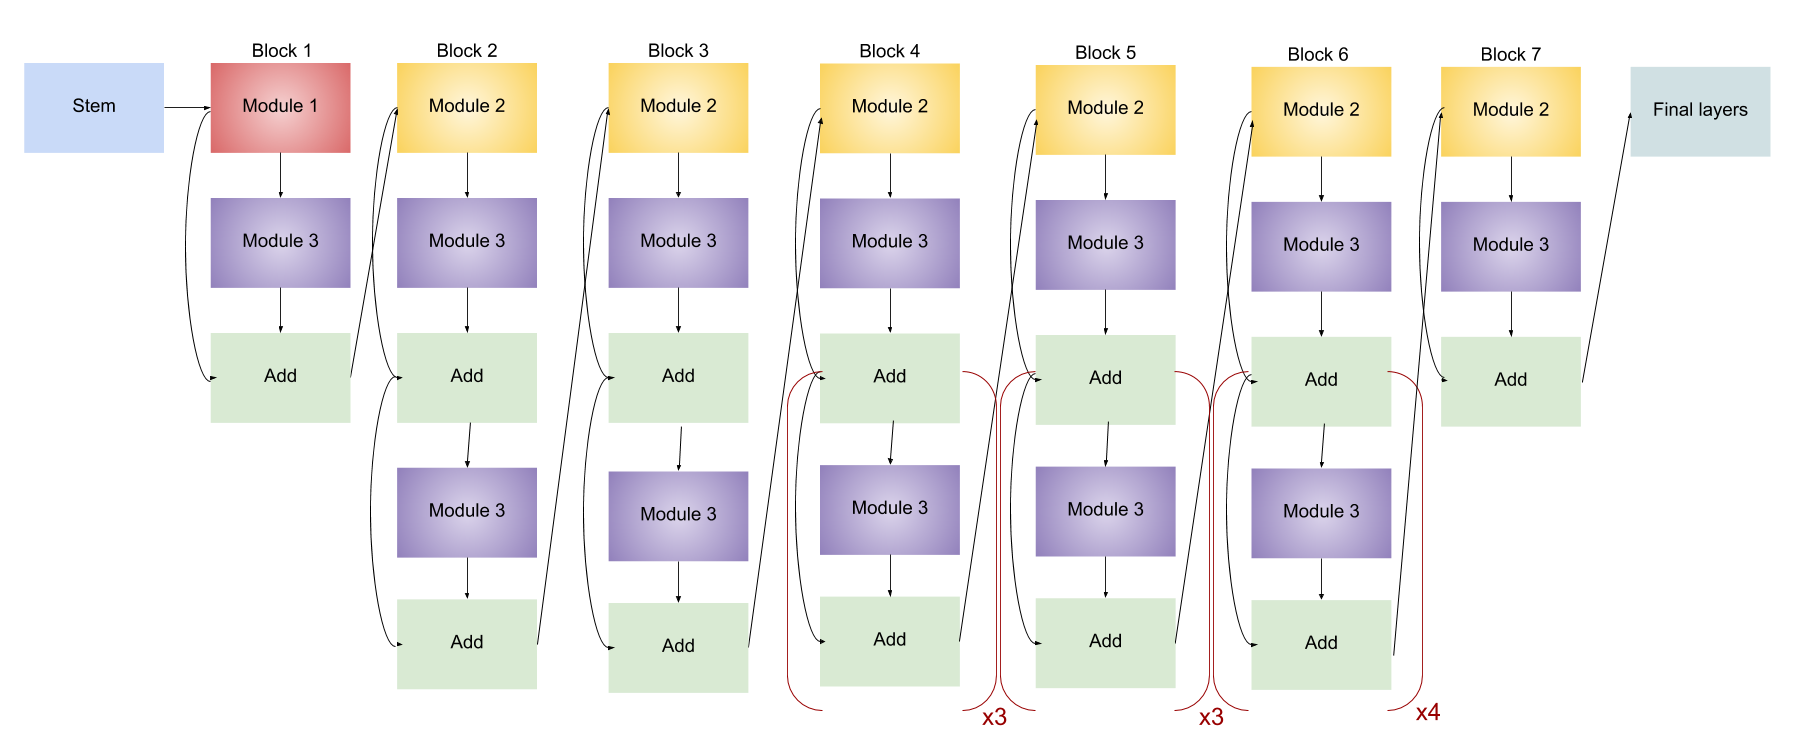

In [ ]:
fem = tfk.applications.EfficientNetV2L(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True
)
tfk.utils.plot_model(fem, show_shapes=True)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

### ConvNeXt

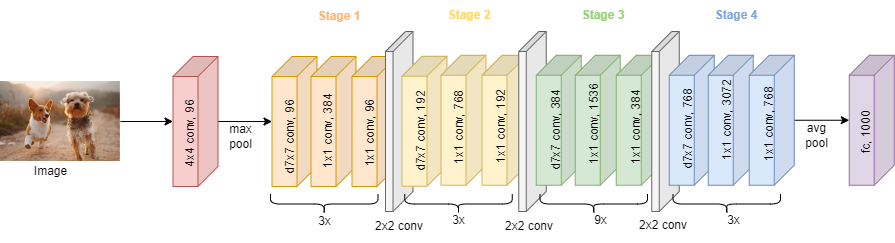

#### ConvNeXtBase

In [ ]:
fem = tfk.applications.ConvNeXtBase(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

#### ConvNeXtLarge

In [ ]:
fem = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)
tfk.utils.plot_model(fem, show_shapes=True)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

#### ConvNeXtXLarge

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

### MobileNetV2

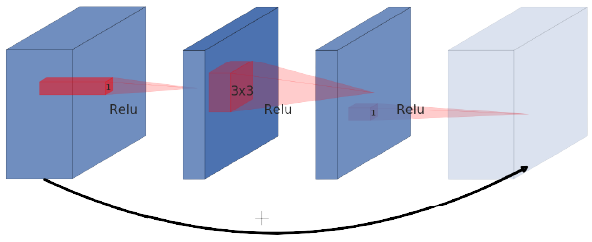

In [ ]:
fem = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
x = fem(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In this section, there is the code to compare the performance of the above-mentioned networks.

In [ ]:
# Function to generate a random color in hexadecimal format
def random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Function to plot the performances of different models
def plot_models_performances(models_history):
    # Generate random colors for each model
    random_colors = [random_color() for _ in range(6)]

    i = 0
    # Create a 2x2 subplot grid with a specified size
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training accuracy for each model in the first subplot
    for name, history in models_history.items():
        axs[0, 0].plot(history['accuracy'], label=name, alpha=.8, color=random_colors[i])
        i += 1

    i = 0
    # Plot validation accuracy for each model in the second subplot
    for name, history in models_history.items():
        axs[0, 1].plot(history['val_accuracy'], label=name, alpha=.8, color=random_colors[i])
        i += 1

    i = 0
    # Plot training loss for each model in the third subplot
    for name, history in models_history.items():
        axs[1, 0].plot(history['loss'], label=name, alpha=.8, color=random_colors[i])
        i += 1

    i = 0
    # Plot validation loss for each model in the fourth subplot
    for name, history in models_history.items():
        axs[1, 1].plot(history['val_loss'], label=name, alpha=.8, color=random_colors[i])
        i += 1

    axs[0, 0].set_title("Train accuracy")
    axs[0, 1].set_title("Validation accuracy")
    axs[1, 0].set_title("Train loss")
    axs[1, 1].set_title("Validation loss")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 1].set_ylabel("Accuracy")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 0].set_ylabel("Loss")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 1].set_xlabel("Epochs")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 0].set_xlabel("Epochs")
    axs[0, 0].legend(loc='lower right')
    axs[0, 1].legend(loc='lower right')
    axs[1, 1].legend(loc='upper right')
    axs[1, 0].legend(loc='upper right')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 1].set_ylim(0, 1)
    axs[1, 1].set_ylim(0, 1)
    axs[1, 0].set_ylim(0, 1)

    plt.grid(alpha=.3)

    plt.show()

In [ ]:
model_histories = {}

for file_name in os.listdir("/content/drive/My Drive/Homework1/baseline_histories"):
  if file_name.endswith(".csv"):
    history = pd.read_csv(os.path.join("/content/drive/My Drive/Homework1/baseline_histories/", file_name))
    model_histories[file_name.rsplit('.', 1)[0]] = history

plot_models_performances(model_histories)

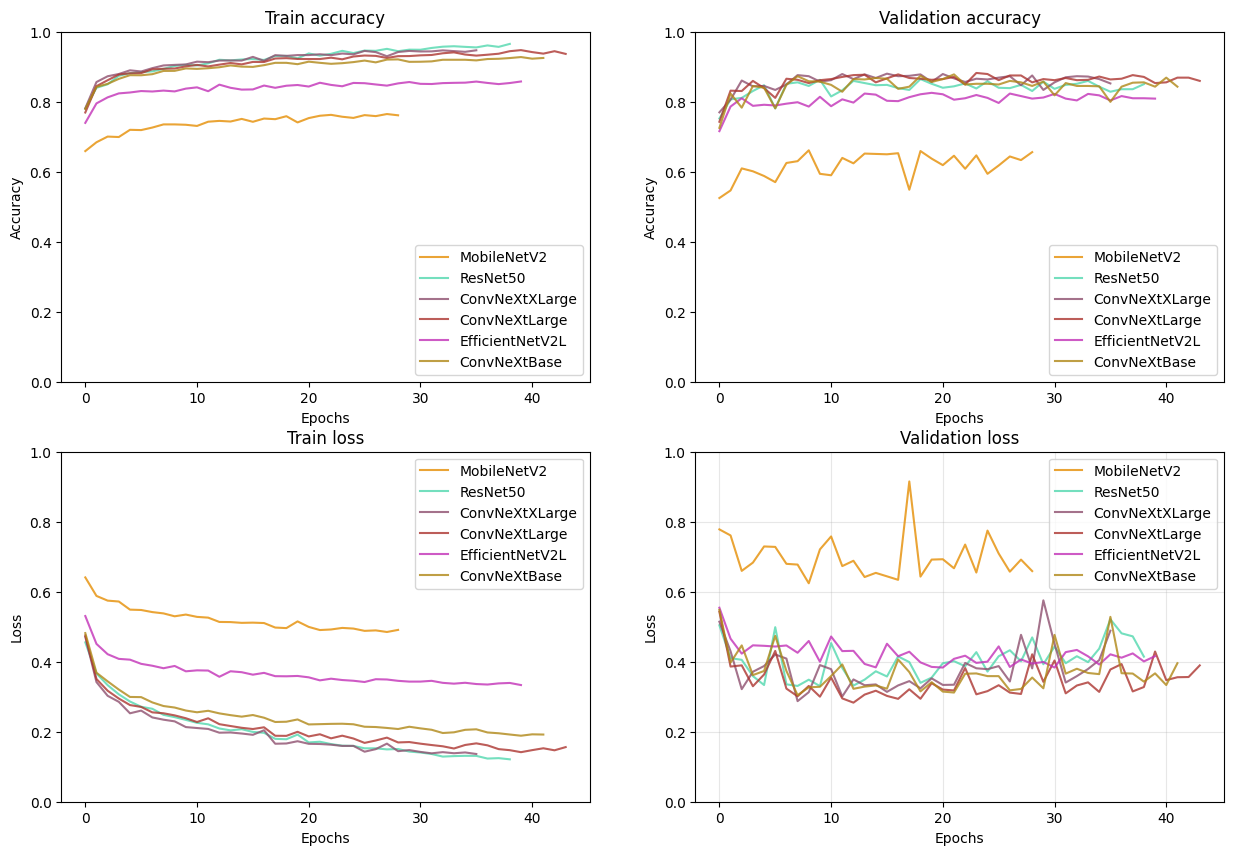

## 🏫 Transfer Learning

This section is about Transfer Learning: specifically, we wanted to delve into the analysis of ConvNeXtXLarge. Firstly, we aimed to assess the model's ability to overfit, to see if it could learn to "memorize" the dataset.

In [ ]:
conv_xl_large = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

tfk.utils.plot_model(conv_xl_large, show_shapes=True)

conv_xl_large.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
inp = conv_xl_large(inputs)

# Neurons number at random
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
pred = tfkl.Dense(2, activation='softmax')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val)
).history

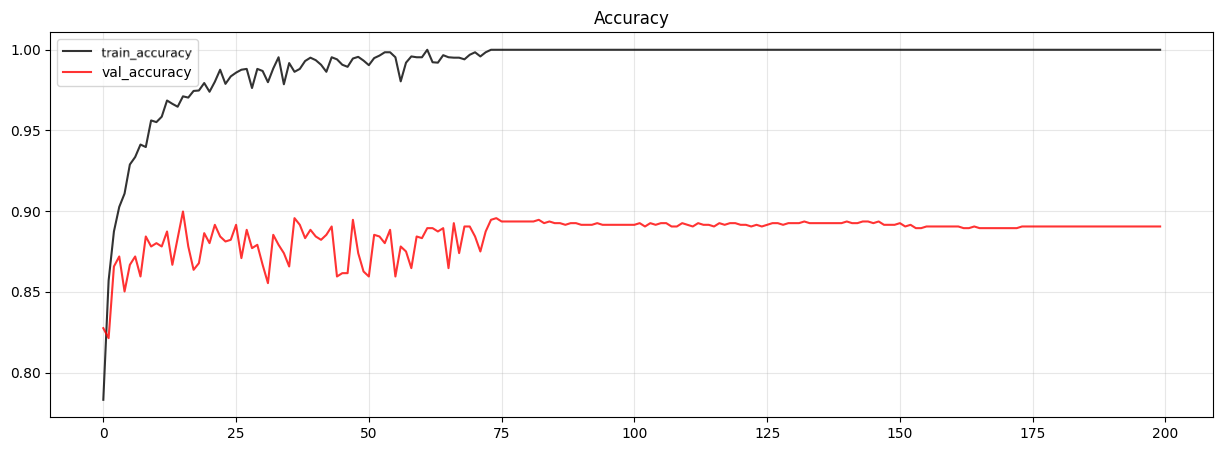



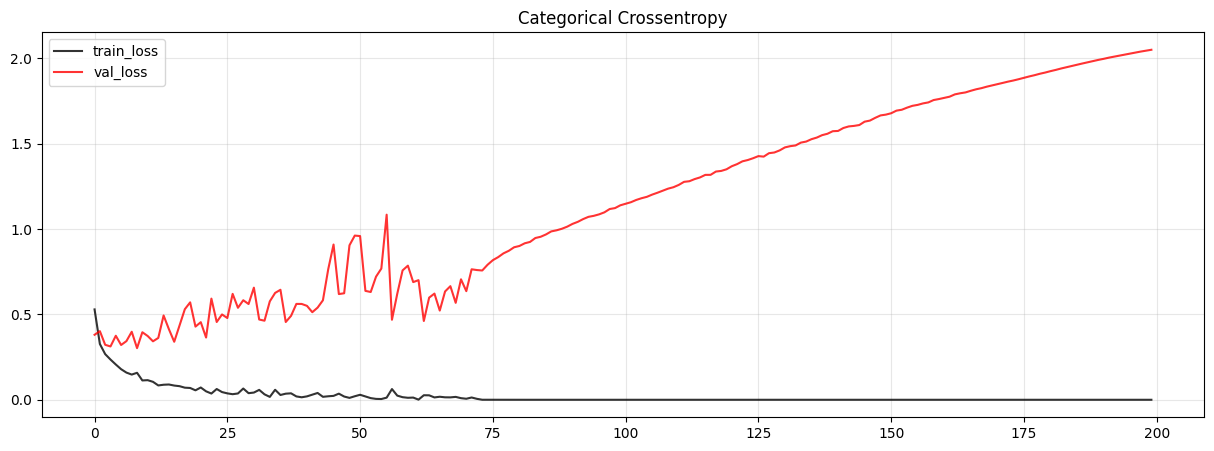

### 🏫 Transfer Learning - Searching the best network architecture

Here, a grid search was performed to find the optimal number of neurons per layer (2) and to determine the best structure (funnel or the same number of neurons per layer).

In [ ]:
def network_architecture_search(X_train, y_train, X_val, y_val, hidden_layers, neurons, funnel, tmp):
    # Initialize a dictionary to store accuracies for different architectures
    accuracies = {}

    if not funnel:
        for n in neurons:
            # Clone the pre-trained model 'tmp' and set it as non-trainable because it has to be new compared to the previous one
            fem_new = tmp
            fem_new.trainable = False

            # Define the input layer
            inputs = tfk.Input(shape=(96, 96, 3))
            inp = fem_new(inputs)

            # Build the neural network architecture with specified hidden layers and neurons
            x = tfkl.Dense(units=n, activation='relu')(inp)
            for _ in range(hidden_layers - 1):
                x = tfkl.Dense(n, activation='relu')(x)

            # Output layer with softmax activation for classification
            pred = tfkl.Dense(2, activation='softmax')(x)
            tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
            tl_model.compile(optimizer=tfk.optimizers.Adam(), loss=tfk.losses.CategoricalCrossentropy(), metrics=["accuracy"])

            # Train the model and store the training history
            history = tl_model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_val, y_val),
                                    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]).history

            # Evaluate the model on the validation set
            loss, accuracy = tl_model.evaluate(X_val, y_val, verbose=0)

            # Store accuracy in the dictionary with the corresponding architecture as the key
            accuracies[" - ".join([str(int) for int in [n] * hidden_layers])] = accuracy

    # If using a funnel architecture
    else:
        # Generate combinations of different numbers of neurons for each layer
        extracted_comb = list(itertools.combinations(neurons, hidden_layers))

        # Iterate over the generated combinations
        for comb in extracted_comb:
            # Clone the pre-trained model 'tmp' and set it as non-trainable
            fem_new = tmp
            fem_new.trainable = False

            # Define the input layer
            inputs = tfk.Input(shape=(96, 96, 3))
            inp = fem_new(inputs)

            # Build the neural network architecture with the specified combination of hidden layers and neurons
            x = tfkl.Dense(units=comb[0], activation='relu')(inp)
            for i in range(1, hidden_layers):
                x = tfkl.Dense(comb[i], activation='relu')(x)

            # Output layer with softmax activation for classification
            pred = tfkl.Dense(2, activation='softmax')(x)

            tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
            tl_model.compile(optimizer=tfk.optimizers.Adam(), loss=tfk.losses.CategoricalCrossentropy(), metrics=["accuracy"])

            # Train the model and store the training history
            history = tl_model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_val, y_val),
                                    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]).history

            # Evaluate the model on the validation set
            loss, accuracy = tl_model.evaluate(X_val, y_val, verbose=0)

            # Store accuracy in the dictionary with the corresponding architecture as the key
            accuracies[" - ".join([str(int) for int in comb])] = accuracy

    # Find the architecture with the highest accuracy
    max_acc = max(accuracies, key=accuracies.get)

    # Return the architecture and its corresponding accuracy
    return max_acc.split(" - "), accuracies.get(max_acc)

fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

y_train, y_val = encoding_labels(y_train, y_val)

best_config = network_architecture_search(X_train, y_train, X_val, y_val, 2, [1024, 512, 128, 64], False, fem)
print(best_config)

best_config_funnel = network_architecture_search(X_train, y_train, X_val, y_val, 2, [1024, 512, 128, 64], True, fem)
print(best_config_funnel)

In [ ]:
# Function to generate a random color in hexadecimal format
def random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Function to plot losses of multiple models along with their accuracies
def plot_models_losses(models_history):
    # Generate random colors for each model
    random_colors = [random_color() for _ in range(10)]

    i = 0
    fig, axs = plt.subplots(10, 2, figsize=(15, 50))

    # Iterate over model histories
    for name, history in models_history.items():
        # Plot training and validation losses for the model
        axs[i, 0].plot(history['loss'], label="Train_loss", alpha=.8, color=random_colors[i])
        axs[i, 0].plot(history['val_loss'], label="Val_loss", alpha=.8, color=random_colors[i-1])
        axs[i, 0].set_title(name)
        axs[i, 0].legend(loc='upper left')
        axs[i, 0].set_xlim(0, 20)
        axs[i, 0].grid(alpha=.3)
        axs[i, 1].plot(history['accuracy'], label="Train_accuracy", alpha=.8, color=random_colors[i])
        axs[i, 1].plot(history['val_accuracy'], label="Val_accuracy", alpha=.8, color=random_colors[i-1])
        axs[i, 1].set_title(name)
        axs[i, 1].legend(loc='upper left')
        axs[i, 1].set_xlim(0, 20)
        axs[i, 1].grid(alpha=.3)

        i += 1

    plt.show()

# Dictionary to store model histories
model_histories = {}

# Load model histories from CSV files in a specified directory
for file_name in os.listdir("/content/drive/My Drive/Homework1/arch_search"):
    if file_name.endswith(".csv"):
        history = pd.read_csv(os.path.join("/content/drive/My Drive/Homework1/arch_search/", file_name))
        model_histories[file_name] = history

# Plot model losses
plot_models_losses(model_histories)

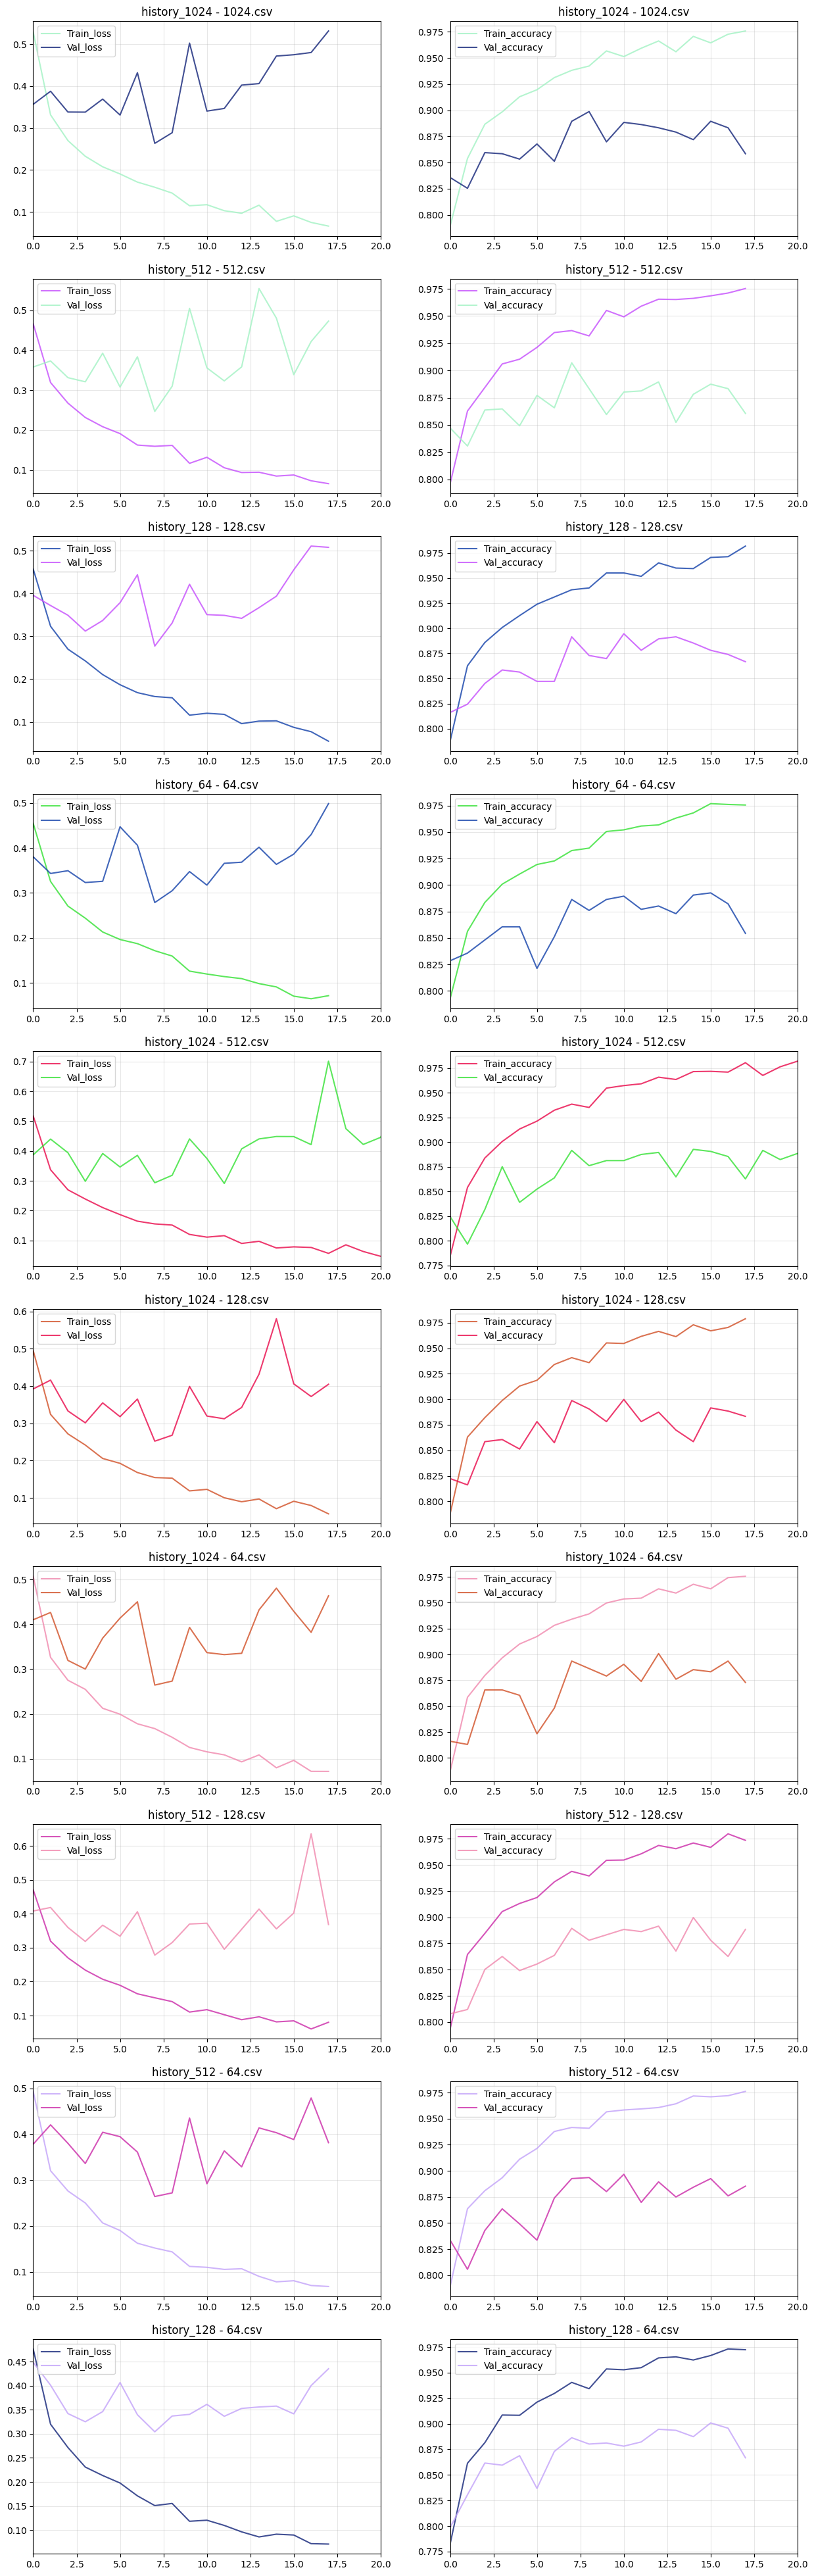

### 🏫 Transfer Learning - Hyperparameter search

As an ideal configuration, we have chosen 512 neurons in the first layer and 64 in the second, thus adopting a funnel structure. The reason for this choice lies in the fact that it seemed to us a good compromise between validation and training loss and accuracy. Often in literature is recommended to have a funnel strcuture to gain higher performances. To address the imbalance in the training set, a sample weighting technique was employed. This involves adjusting the weights in the loss function to give the model a better opportunity to learn from both the healthy and unhealthy classes.

In [ ]:
def get_class_weights():
  # Check if the target variable has more than one dimension
  if len(list(y_train.shape)) > 1:
    # if y_train is already encoded
    class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                     classes=np.unique(np.argmax(y_train, axis=1)),
                                                     y=np.argmax(y_train, axis=1))
  else:
    # if y_train is not already encoded
    class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                     classes=np.unique(y_train),
                                                     y=y_train)

  # Create a dictionary mapping class indices to their respective weights
  class_weights = dict(zip([0, 1], class_weights))
  # Return the calculated class weights
  return class_weights


print(get_class_weights())

In the function below, a search for optimal parameters is conducted with respect to learning rate, batch size, and regularization.

In [ ]:
def hyperparameter_search(learning_rates, batch_sizes, regularizations, X_train, y_train, X_val, y_val, fem):
    # Initialize a dictionary to store accuracies for different hyperparameter configurations
    accuracies = {}

    # Iterate over learning rates
    for lr in learning_rates:
        # Iterate over batch sizes
        for bs in batch_sizes:
            # Iterate over regularization values
            for l2 in regularizations:
                print("Configuration " + str(lr) + "_" + str(bs) + "_" + str(l2))

                # Clone the pre-trained model 'tmp' and set it as non-trainable because it has to be new compared to the previous one
                fem_new = fem
                fem_new.trainable = False

                # Define the input layer
                inputs = tfk.Input(shape=(96, 96, 3))
                inp = fem_new(inputs)

                # Build the neural network architecture with specified hyperparameters
                x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1', kernel_regularizer=tf.keras.regularizers.l2(l2))(inp)
                x = tfkl.Activation('relu', name='HiddenActivation1')(x)
                x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2', kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
                x = tfkl.Activation('relu', name='HiddenActivation2')(x)
                pred = tfkl.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2))(x)

                tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
                tl_model.compile(optimizer=tfk.optimizers.Adam(learning_rate=lr), loss=tfk.losses.CategoricalCrossentropy(), metrics=["accuracy"])

                # Train the model and store the training history
                history = tl_model.fit(X_train, y_train, batch_size=bs, epochs=200, validation_data=(X_val, y_val), class_weight=get_class_weights(), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]).history

                # Save the training history to a CSV file
                hist_df = pd.DataFrame(history)
                hist_df.to_csv("/content/drive/My Drive/Homework1/baseline_hypersearch/history_" + str(lr) + "_" + str(bs) + "_" + str(l2) + ".csv")

                # Evaluate the model on the validation set
                loss, accuracy = tl_model.evaluate(X_val, y_val, verbose=0)

                # Store accuracy in the dictionary with the corresponding hyperparameter configuration as the key
                accuracies[str(lr) + "_" + str(bs) + "_" + str(l2)] = accuracy

                # Print and save the accuracies during the search
                print(accuracies)
                df = pd.DataFrame(list(accuracies.items()), columns=['key', 'Accuracy'])
                df.to_csv('/content/drive/My Drive/Homework1/accuracies_hypersearch/accuracies_records_ptfinal2.csv')

    # Return the dictionary of accuracies for each hyperparameter configuration
    return accuracies

fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

y_train, y_val = encoding_labels(y_train, y_val)
hyperparameter_search([0.001, 0.0001, 0.00001], [16, 32, 64, 128], [0, 2e-5], X_train, y_train, X_val, y_val, fem)


In [ ]:
# Function to generate a random color in hexadecimal format
def random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Function to plot losses of multiple models along with their accuracies
def plot_models_losses(models_history, acc_hyper):
    # Generate random colors for each model
    random_colors = [random_color() for _ in range(24)]

    # Convert the 'key' column in acc_hyper to string type
    acc_hyper['key'] = acc_hyper['key'].astype(str)

    i = 0
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))

    # Iterate over model histories
    for name, history in models_history.items():
        # Extract key value from the model name
        key_value = '_'.join(name.split('_')[1:])[:-4]

        # Check if the key value is present in the accuracy dataframe
        if key_value in acc_hyper['key'].values:
            # Create a plot title with model name and accuracy
            plot_title = f"Model: {name}, Accuracy: {acc_hyper.loc[acc_hyper['key'] == key_value, 'Accuracy'].values[0]}"

            # Plot training and validation losses for the model
            axs.plot(history['accuracy'], label="Train_loss", alpha=.8, color=random_colors[i])
            axs.plot(history['val_accuracy'], label="Val_loss", alpha=.8, color=random_colors[i-1])
            axs.set_title(plot_title)
            axs.legend(loc='upper left')
            axs.set_xlim(0, 15)
            i += 1

        break

    plt.grid(alpha=.3)
    plt.show()

# Dictionary to store model histories
model_histories = {}

# Load model histories from CSV files in a specified directory
for file_name in os.listdir("/content/drive/My Drive/Homework1/histories_hypersearch2"):
    if file_name.endswith(".csv"):
        history = pd.read_csv(os.path.join("/content/drive/My Drive/Homework1/histories_hypersearch2/", file_name))
        model_histories[file_name] = history

# Load accuracies data from a CSV file
acc_hyper = pd.read_csv("/content/drive/My Drive/Homework1/accuracies_hypersearch2/accuracies_records_ptfinal2.csv")

# Plot model losses along with accuracies
plot_models_losses(model_histories, acc_hyper)

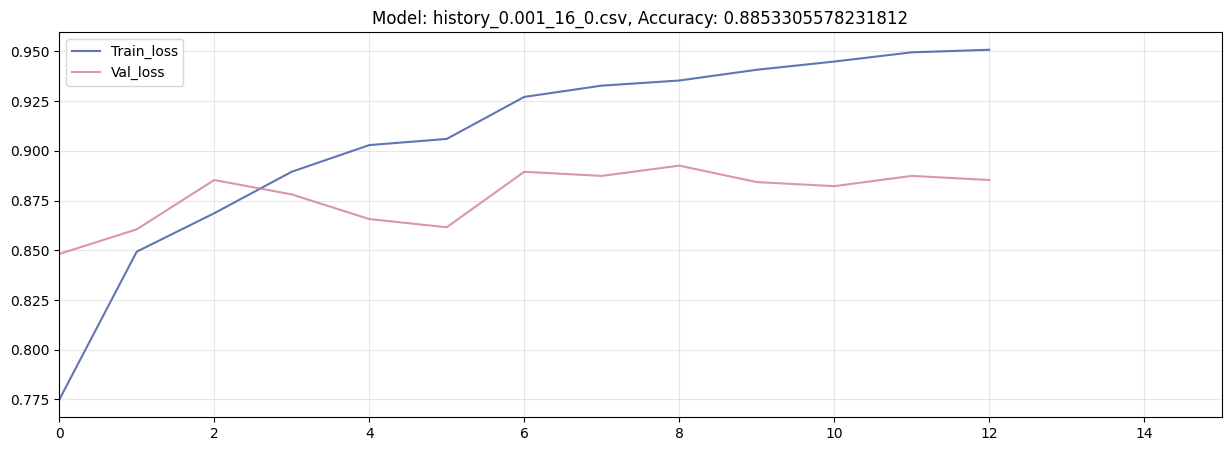

After several trials, omitted for sake of readability, the best results, especially in terms of balancing false positives and false negatives, were obtained with batch size = 16, learning rate = 0.001, and regularization = 0.

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
inp = fem(inputs)

x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
pred = tfkl.Dense(2, activation='softmax')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    class_weight = get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, tl_model)
model_save(tl_model,"/content/drive/My Drive/Homework1/models/transfer_learning_models/weighted_final_train")

We obtained this result on our validation set:

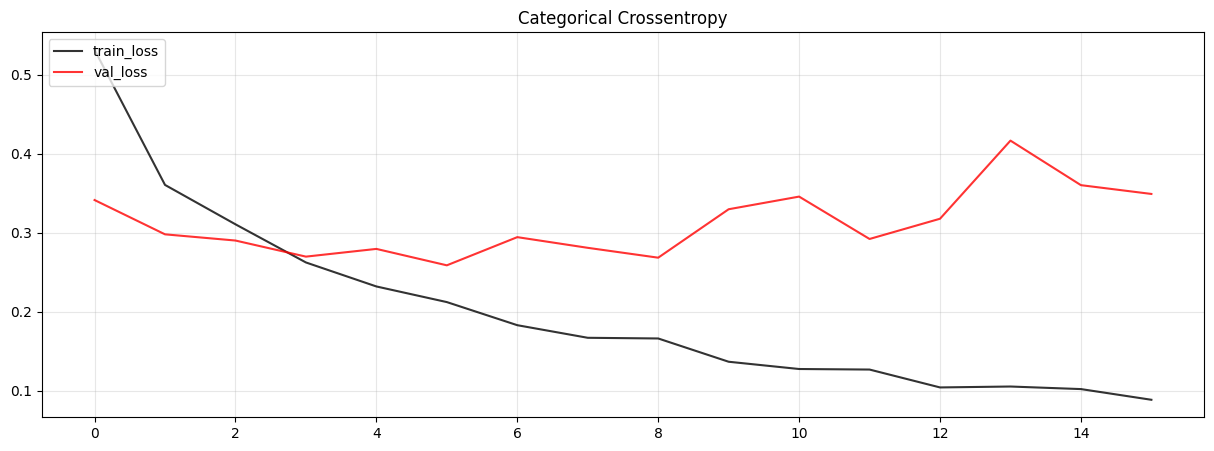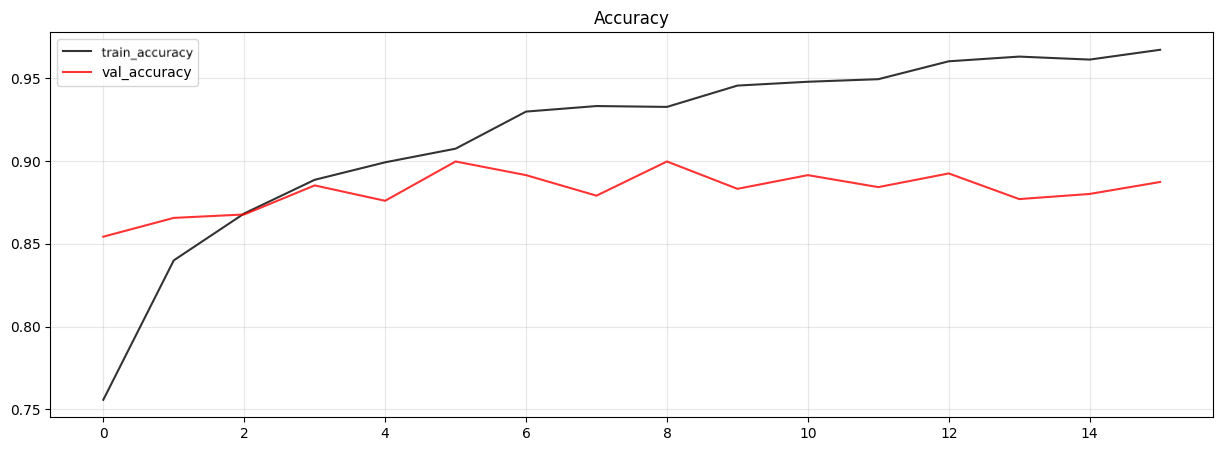
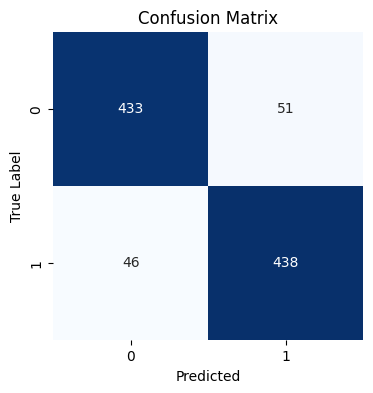

Accuracy: 0.89
Recall: 0.90
Precision: 0.89
F1-score: 0.90

## ↗️ Data augmentation

To mitigate potential overfitting, we delved into the concept of data augmentation, specifically attempting to expand the dataset creating one balanced, SMOTE approach and creating a dedicated preprocessing layer.

In [ ]:
NUM_TRANSF = 4

# Define different random transformations using TensorFlow layers
r_flip_h = tf.keras.Sequential([tfkl.RandomFlip("horizontal")], name='r_flip_h')
r_flip_v = tf.keras.Sequential([tfkl.RandomFlip("vertical")], name='r_flip_v')
r_rot = tf.keras.Sequential([tfkl.RandomRotation(0.4)], name='r_rot')
r_tra = tf.keras.Sequential([tfkl.RandomTranslation(0.4, 0.4)], name='r_tra')

def balance_with_SMOTE(X, y):
  smt = SMOTE()
  tr = X.shape[0]
  X = X.reshape(tr,-1)
  X_smt, y_smt = smt.fit_resample(X,y)
  return X_smt.reshape(-1,96,96,3),y_smt

# Function to apply a random transformation to an image
def random_transformation(img, transf):
    transf_img = None
    img = img.reshape(1, 96, 96, 3)
    if(transf == 0):
        transf_img = r_flip_h(img)
    elif(transf == 1):
        transf_img = r_flip_v(img)
    elif(transf == 2):
        transf_img = r_rot(img)
    else:
        transf_img = r_tra(img)
    return transf_img

# Function for augmented balancing of the dataset
def augmeted_balancing(X, y, extend_dataset=0):

    if(len(list(y.shape)) > 1):
      y = np.where(y == 0, "healthy", "unhealthy")

    aug_X, aug_y = np.array(X).copy(), np.array(y).copy()

    # Count occurrences of healthy and unhealthy classes
    healthy, unhealthy = np.unique(y, return_counts=True)[1][0], np.unique(y, return_counts=True)[1][1]

    # Calculate the imbalance in the dataset
    delta =  healthy - unhealthy
    u_indices = np.where(y == 'unhealthy')[0]
    # Check if the imbalance is greater than the number of samples in the minority class
    if delta > unhealthy:
        print("delta > minority class count")
        return

    # Augment the dataset by applying random transformations to samples in the minority class
    for i in range(delta):
        sampled_idx = np.random.randint(0, len(u_indices))
        target = u_indices[sampled_idx]
        u_indices = np.delete(u_indices, sampled_idx)
        transf_img = random_transformation(aug_X[target], random.randint(0, NUM_TRANSF))
        aug_X = np.append(aug_X, transf_img, axis=0)
        aug_y = np.append(aug_y, 'unhealthy')

    # Re-calculate indices of unhealthy and healthy samples in the augmented dataset
    u_indices = np.where(y == 'unhealthy')[0]
    h_indices = np.where(y == 'healthy')[0]

    # Augment the dataset by applying random transformations to samples in both classes
    for j in range(0, len(u_indices)):
        if not j % 2:
            sampled_idx = np.random.randint(0, len(u_indices))
            target = u_indices[sampled_idx]
            transf_img = random_transformation(aug_X[target], random.randint(0, NUM_TRANSF))
            aug_X = np.append(aug_X, transf_img, axis=0)
            aug_y = np.append(aug_y, 'unhealthy')
        else:
            sampled_idx = np.random.randint(0, len(h_indices))
            target = h_indices[sampled_idx]
            transf_img = random_transformation(aug_X[target], random.randint(0, NUM_TRANSF))
            aug_X = np.append(aug_X, transf_img, axis=0)
            aug_y = np.append(aug_y, 'healthy')

    # Shuffle the augmented dataset and return
    return shuffle(aug_X, aug_y)

# Print shapes before and after augmentation
print(X_train.shape, y_train.shape)
X_train, y_train = augmeted_balancing(X_train, y_train)
print(X_train.shape, y_train.shape)


Now the previously obtained best model has been trained using these data augmentation techniques.

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))
inp = fem(inputs)

x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
pred = tfkl.Dense(2, activation='softmax')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    class_weight = get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, tl_model)

The obtained performances on validation set and similar with SMOTE are:

Accuracy: 0.89
Recall: 0.89
Precision: 0.90
F1-score: 0.89

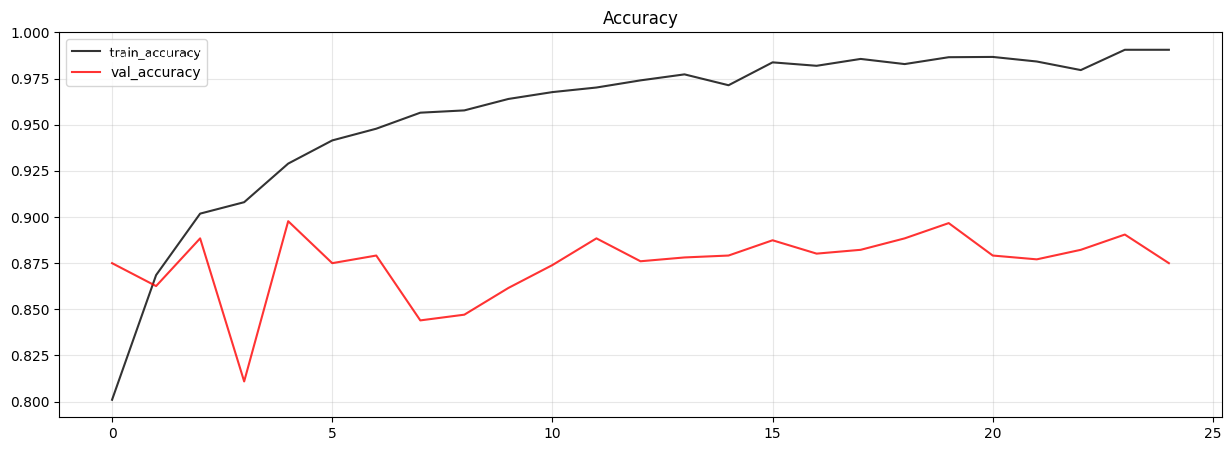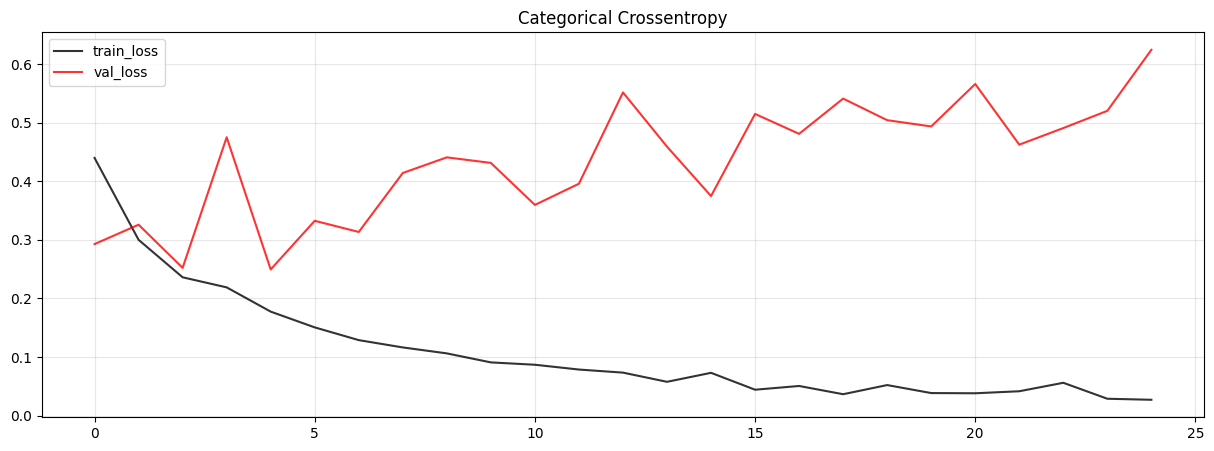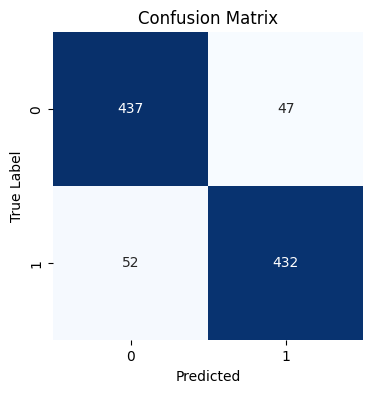

The result of this operation, as shown in the graphs above, leads to worse performances. All of this has led us to consider a preprocessing layer designed to apply transformations during the training phase.

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))

preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip("horizontal"),
      tfkl.RandomFlip("vertical"),
      tfkl.RandomRotation(0.4),
      tfkl.RandomTranslation(0.4,0.4),
], name='preprocessing')

preprocessing = preprocessing(inputs)
inp = fem(preprocessing)
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
pred = tfkl.Dense(2, activation='softmax')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    class_weight = get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, tl_model)

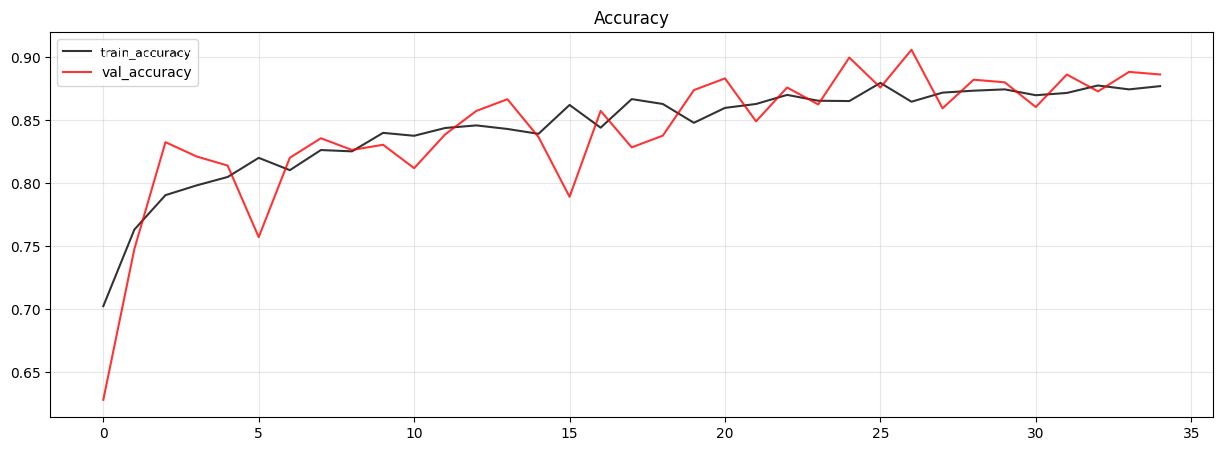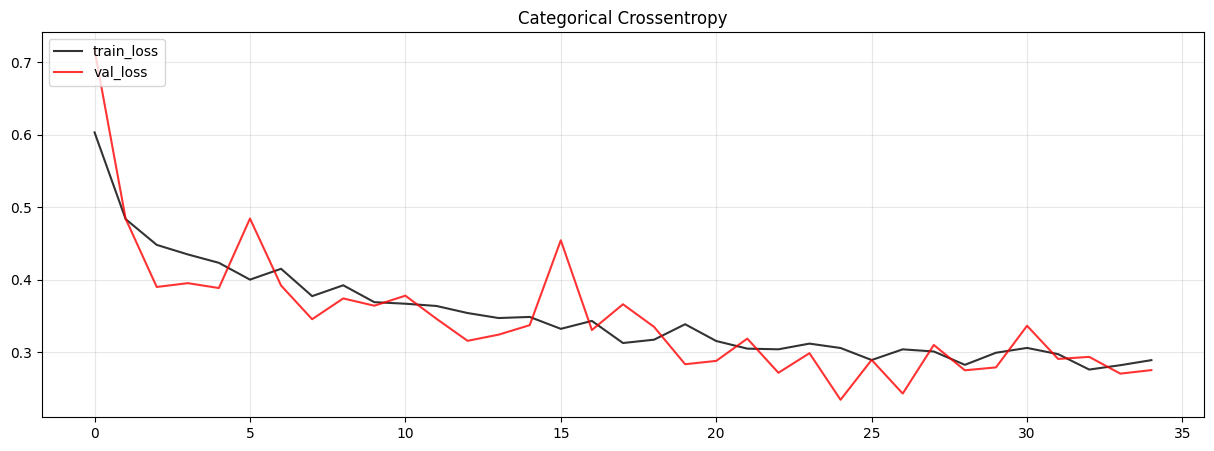

From the above graphs, it can be observed that the current situation in terms of overfitting has significantly improved (always on our validation set)

## 🎯 Fine-tuning

To further enhance the performance of the model created with Transfer Learning, an attempt has been made to delve deeper into the topic of fine-tuning.

Initially, the best model previously created, the one without data augmentation, was loaded. We attached downstream layers to the Feature Extraction Model (FEM), which has the preprocessing layer. This was done to attempt fine-tuning an architecture in which the preprocessing layer is utilized only once.

In [ ]:
tl_model = tfk.models.load_model('/content/drive/My Drive/Homework1/models/transfer_learning_models/weighted_final_train')
tl_model.summary()

In [ ]:
def unfreeze_range(model, fem_name, freeze_until):
    # Set the Feature Extraction Model (FEM) layer and the layers before 'freeze_until' to be trainable
    model.get_layer(fem_name).trainable = True
    for i, layer in enumerate(model.get_layer(fem_name).layers[:freeze_until]):
        layer.trainable = False

    # Initialize variables to track the range of frozen and unfrozen layers
    flag = True
    freezed_ranges = {"freezed_from": 0}

    # Determine the range of frozen and unfrozen layers based on their trainable status
    for i, layer in enumerate(model.get_layer(fem_name).layers):
        if(layer.trainable and flag):
            freezed_ranges['freezed_to'] = i - 1
            freezed_ranges['unfreezed_from'] = i
            flag = False

    freezed_ranges["unfreezed_to"] = len(model.get_layer(fem_name).layers) - 1

    # Return the ranges of frozen and unfrozen layers along with the updated model
    return freezed_ranges, model

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

inputs = tfk.Input(shape=(96, 96, 3))

# Preprocessing layer able to transform images
preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip("horizontal"),
      tfkl.RandomFlip("vertical"),
      tfkl.RandomRotation(0.4),
      tfkl.RandomTranslation(0.4,0.4),
], name='preprocessing')

preprocessing = preprocessing(inputs)
inp = fem(preprocessing)
x = tl_model.get_layer("HiddenDense1")(inp)
x = tl_model.get_layer("HiddenActivation1")(x)
x = tl_model.get_layer("HiddenDense2")(x)
x = tl_model.get_layer("HiddenActivation2")(x)
pred = tl_model.layers[-1](x)

joined_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
joined_model.summary()

# Unfreeze the fem by a treshold
fem_name = 'convnext_xlarge'
freeze_treshold = 51
freeze_summary, ft_model = unfreeze_range(model = joined_model, fem_name = fem_name, freeze_until = freeze_treshold)

print("\n\n")
for i, layer in enumerate(tl_model.get_layer(fem_name).layers):
   print(i, layer.name, layer.trainable)

y_train, y_val = encoding_labels(y_train, y_val)
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
ft_model.summary()

history = ft_model.fit(
    class_weight=  get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, ft_model)

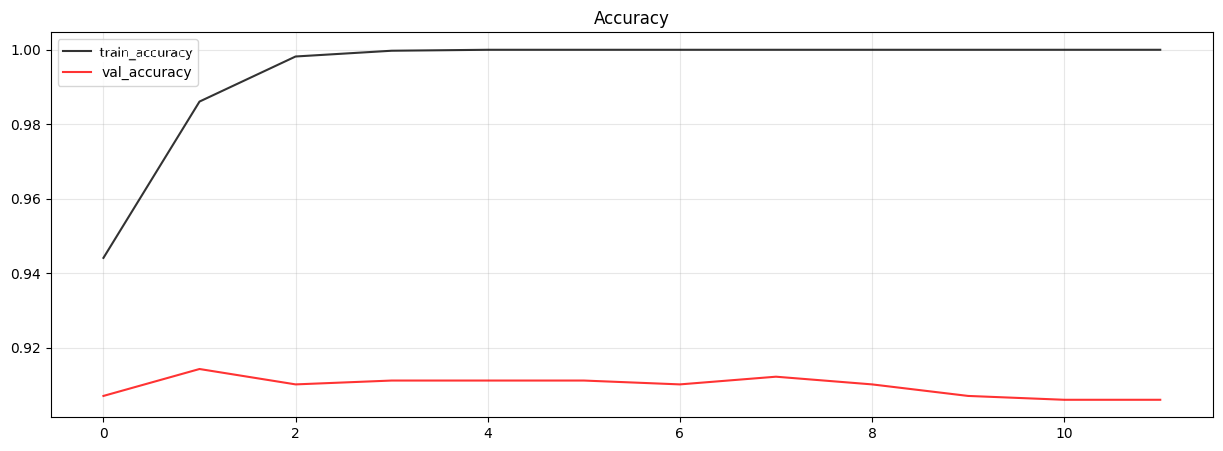
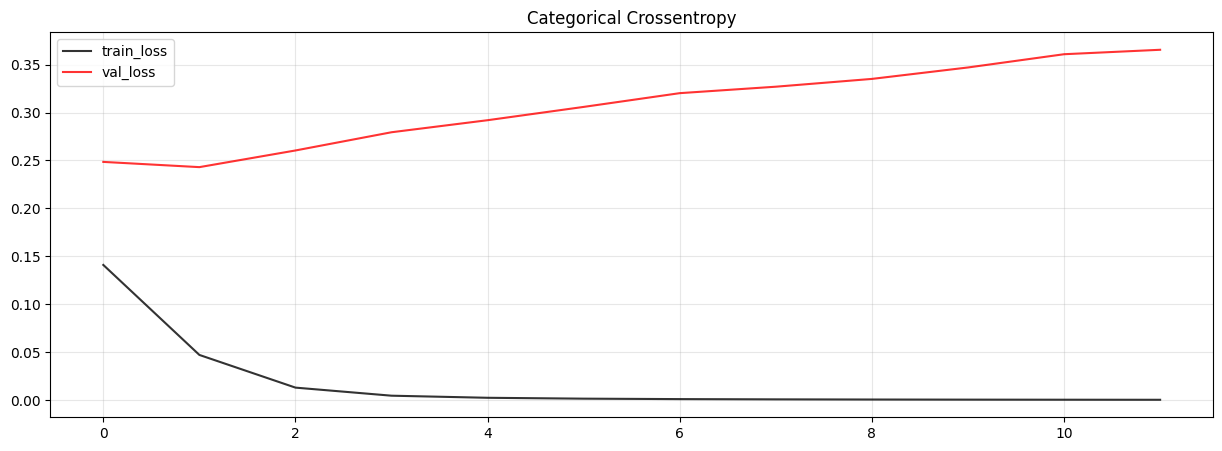

As we can see from the charts above, this configuration has led us to an important overfitting situation. For this reason, we have considered some strategies to reduce it: one of them was about regularization.

### ⬇️ Trying to reduce overfitting

As mentioned earlier, the main problem is overfitting. For this reason, two approaches have been followed:


*   Tune transformation parameters
*   Try different regularization values

#### ♻️ Tuning transformation parameters

In this section, a search for the best transformations and optimal unfreeze threshold was conducted using Keras Tuner. The best-found transformations include RandomFlip horizontal, RandomFlip vertical, RandomRotation = 0.2, and RandomTranslation = (0.2, 0.2). The optimal threshold value is 51 (thus, many layers of the pre-trained network were unfrozen).

In [ ]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(96, 96, 3))

    # Define a preprocessing layer with random flips, rotations, and translations
    preprocessing_layer = Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomFlip("vertical"),
        preprocessing.RandomRotation(hp.Float('rotation', min_value=0, max_value=1, step=0.1)),
        preprocessing.RandomTranslation(
            height_factor=hp.Float('height_translation', min_value=0, max_value=1, step=0.1),
            width_factor=hp.Float('width_translation', min_value=0, max_value=1, step=0.1)),
    ], name='preprocessing')

    x = preprocessing_layer(inputs)
    x = fem(x)

    # Add dense layers to the model with hyperparameter tuning for units and initialization
    x = tf.keras.layers.Dense(units=512, kernel_initializer=tf.keras.initializers.HeUniform(seed=seed), name='HiddenDense1')(x)
    x = tf.keras.layers.Activation('relu', name='HiddenActivation1')(x)
    x = tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
    x = tf.keras.layers.Activation('relu', name='HiddenActivation2')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    tl_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    fem_name = 'convnext_xlarge'

    # Hyperparameter for freezing layers until a specified threshold
    freeze_threshold = hp.Int('freeze_threshold', min_value=51, max_value=268, step=108)

    # Unfreeze layers in the specified range
    freeze_summary, ft_model = unfreeze_range(model=tl_model, fem_name=fem_name, freeze_until=freeze_threshold)

    # Compile the model with categorical crossentropy loss and Adam optimizer
    tl_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

    return tl_model

# Bayesian Optimization tuner setup
tuner = BayesianOptimization(
    build_model,
    objective=kt.Objective('val_loss', 'min'),
    max_trials=15,
    num_initial_points=3,
    max_consecutive_failed_trials=50
)

# Perform hyperparameter search using the tuner
tuner.search(class_weight = get_class_weights(), x=X_train, y=y_train, batch_size=16, epochs=200, validation_data=(X_val, y_val), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)])

# Display results summary
tuner.results_summary()

# Get the best hyperparameters from the search
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(best_hps)


#### ♻️ Trying different regularization values

After obtaining the best parameters for image transformations, we focused on managing the regularization parameters.
To try to limit overfitting quite strongly, we decided to replicate the training done on the previous model using Transfer Learning, with the difference that we introduced regularization parameters. In this way, we aimed to bring the model slightly into underfitting, later leading it to a reasonable solution by unfreezing the previous layers. The desired effect is to obtain a model that is less powerful initially and then more powerful after unfreezing the layers.

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))

# Preprocessing layer able to transform images
preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip("horizontal"),
      tfkl.RandomFlip("vertical"),
      tfkl.RandomRotation(0.2),
      tfkl.RandomTranslation(0.2,0.2),
], name='preprocessing')

preprocessing = preprocessing(inputs)
inp = fem(preprocessing)
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1', kernel_regularizer=tf.keras.regularizers.l2(2e-3))(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2', kernel_regularizer=tf.keras.regularizers.l2(2e-3))(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
pred = tfkl.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(2e-3))(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    class_weight = get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, tl_model)

Two regularization values were tested: 2e-5 and 2e-3 (see below):

2e-5
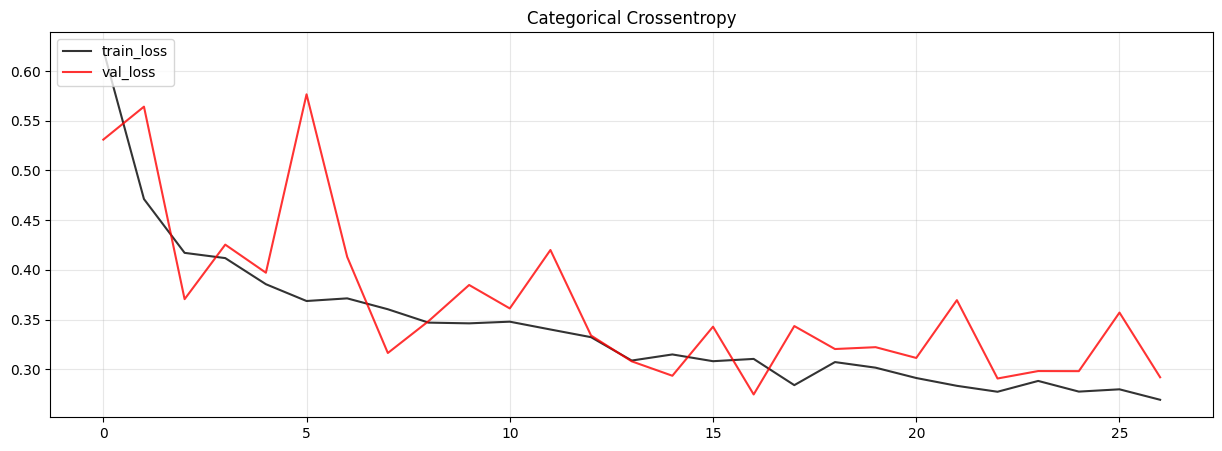

2e-3
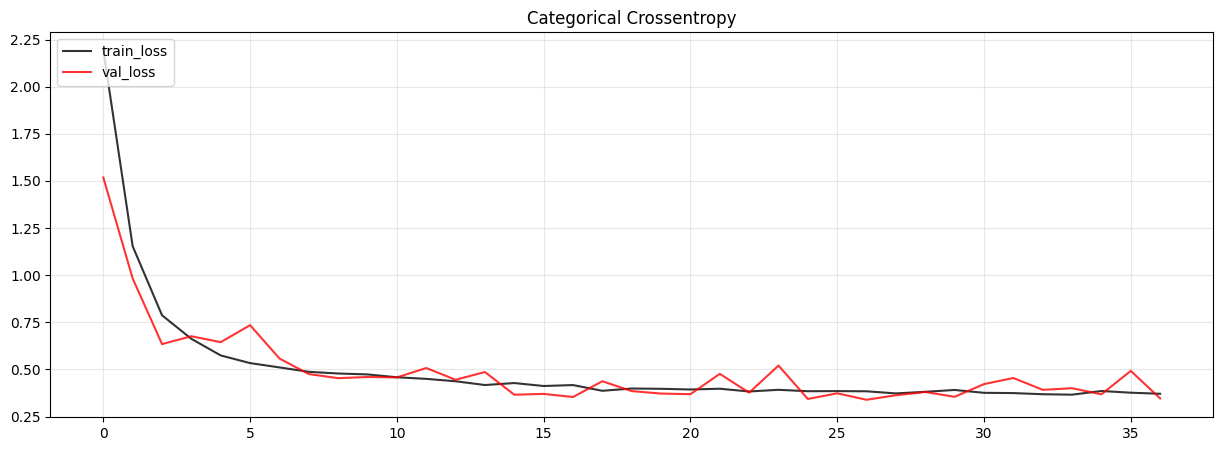


We chose a regularization value of 2e-3 as it exhibits a less noisy and smoother loss curve. The confusion marix is:
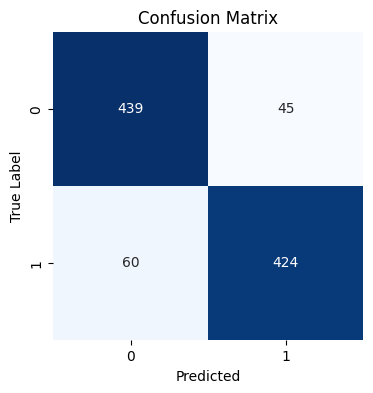

and in particular we obtained:

Accuracy: 0.89

Recall: 0.87

Precision: 0.90

F1-score: 0.88

Now let's fine tune it!

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem_name = 'convnext_xlarge'
freeze_treshold = 51
freeze_summary, ft_model = unfreeze_range(model = tl_model, fem_name = fem_name, freeze_until = freeze_treshold)

print(freeze_summary)
print("\n\n")
for i, layer in enumerate(tl_model.get_layer(fem_name).layers):
   print(i, layer.name, layer.trainable)

y_train, y_val = encoding_labels(y_train, y_val)
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

history = ft_model.fit(
    class_weight=  get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, ft_model)

After fine tuning we otbained several improvements on our validation set:

Accuracy: 0.92

Recall: 0.90

Precision: 0.93

F1-score: 0.92

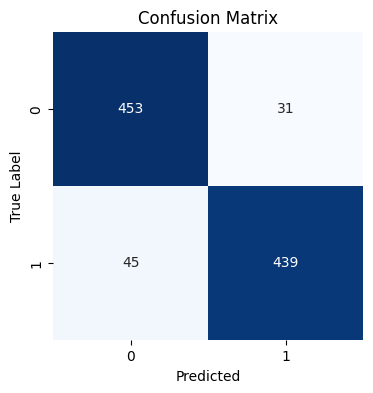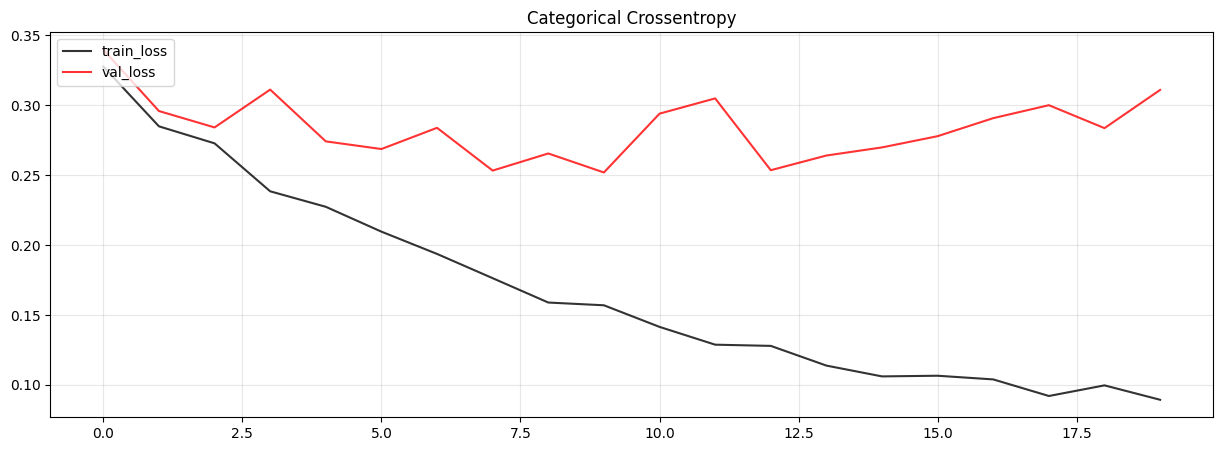

That model achieved the following performances on the first hidden test set (respectively accuracy, precision, recall, F1-score):

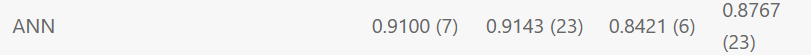

Now, the same model in the second hidden test reached the following perfomances:

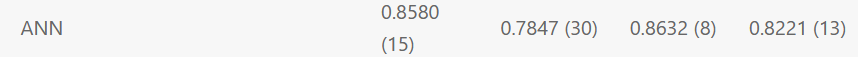

Clearly, this drop in performance is due to the slight overfitting evident in the above graph. Therefore, to address this issue, and as is common practice, we combined the training and validation sets and retrained the entire model.


In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem_name = 'convnext_xlarge'
freeze_treshold = 51
freeze_summary, ft_model = unfreeze_range(model = tl_model, fem_name = fem_name, freeze_until = freeze_treshold)

print(freeze_summary)
print("\n\n")
for i, layer in enumerate(tl_model.get_layer(fem_name).layers):
   print(i, layer.name, layer.trainable)

y_train, y_val = encoding_labels(y_train, y_val)

X = np.concatenate((X_train,X_val))
y = np.concatenate((y_train, y_val))

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

history = ft_model.fit(
    class_weight=  get_class_weights(),
    x = X,
    y = y,
    batch_size = 16,
    epochs = 13,
).history

We obtained the following perfomances on the second hidden test:

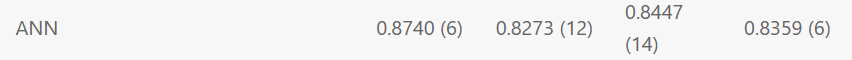

#### ♻️ Further and deeper trials

Conscious of attempting to reduce more overfitting, we conducted a **manual** random search with multiple attempts to achieve the most homogeneus losses possible. From this point onward, the **most successful** result is displayed below.
This model is always based on the concept of regularization, but especially with dropout and some different transformation values.

First, Transfer Learning:

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem.trainable = False
inputs = tfk.Input(shape=(96, 96, 3))

# Preprocessing layer able to transform images
preprocessing = tf.keras.Sequential([
      tfkl.RandomFlip("horizontal"),
      tfkl.RandomFlip("vertical"),
      tfkl.RandomRotation(0.3),
      tfkl.RandomTranslation(0.4,0.6),
], name='preprocessing')

dropout_rate = 0.4

preprocessing = preprocessing(inputs)
inp = fem(preprocessing)
x = tfkl.Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(inp)
x = tfkl.Activation('relu', name='HiddenActivation1')(x)
x = tfkl.Dropout(dropout_rate, seed=seed)(x)
x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
x = tfkl.Activation('relu', name='HiddenActivation2')(x)
x = tfkl.Dropout(dropout_rate, seed=seed)(x)
pred = tfkl.Dense(2, activation='softmax')(x)

tl_model = tfk.Model(inputs=inputs, outputs=pred, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

y_train, y_val = encoding_labels(y_train, y_val)

history = tl_model.fit(
    class_weight = get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, tl_model)

We obtained:

Accuracy: 0.90

Recall: 0.89

Precision: 0.90

F1-score: 0.90

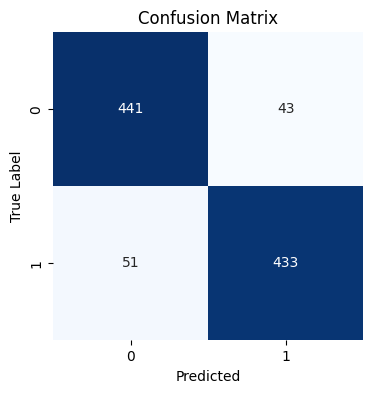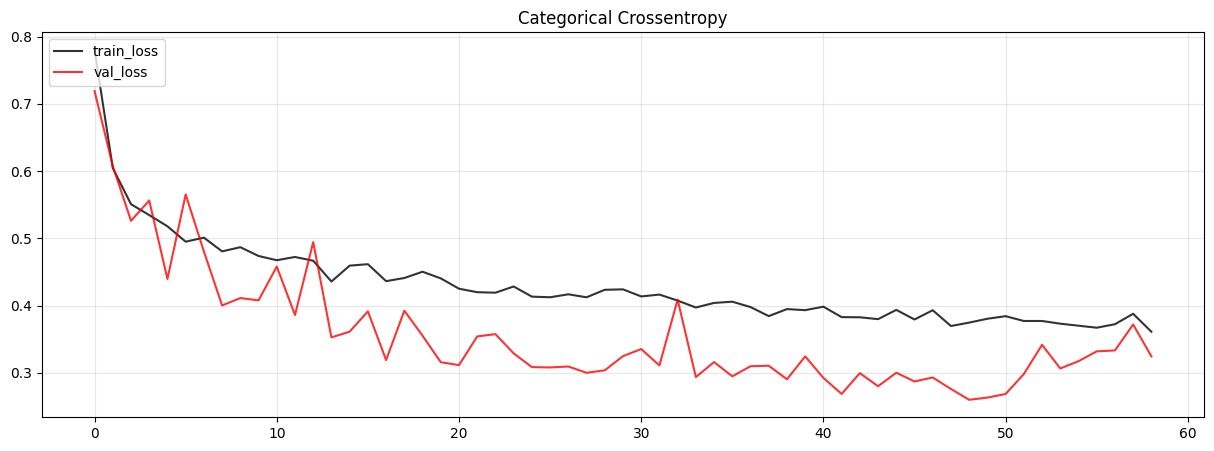
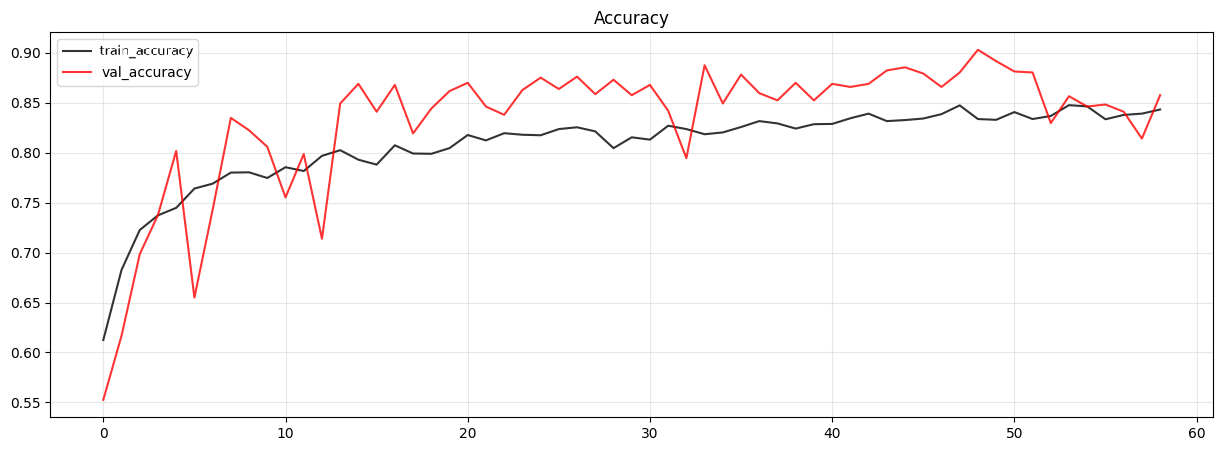

Then, Finetuning and re-trained with train and validation together as before:

In [ ]:
fem = tfk.applications.ConvNeXtXLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing = True
)

fem_name = 'convnext_xlarge'
freeze_treshold = 51
freeze_summary, ft_model = unfreeze_range(model = tl_model, fem_name = fem_name, freeze_until = freeze_treshold)

print(freeze_summary)
print("\n\n")
for i, layer in enumerate(tl_model.get_layer(fem_name).layers):
   print(i, layer.name, layer.trainable)

y_train, y_val = encoding_labels(y_train, y_val)

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

history = ft_model.fit(
    class_weight=  get_class_weights(),
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
).history

eval_model(X_val, y_val, history, ft_model)

We obtained on our validation set these perfomances:

Accuracy: 0.93

Recall: 0.93

Precision: 0.93

F1-score: 0.93

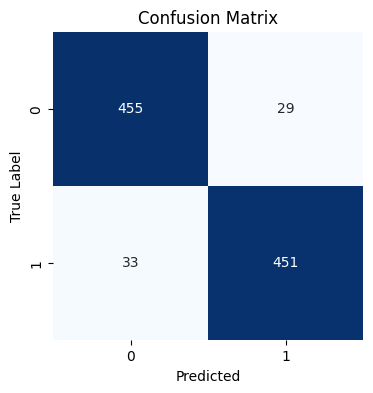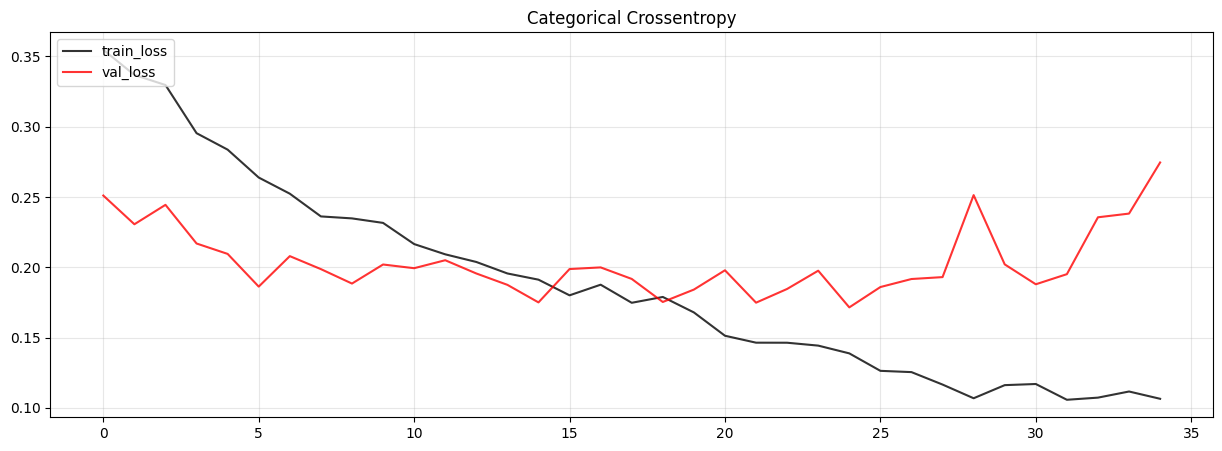
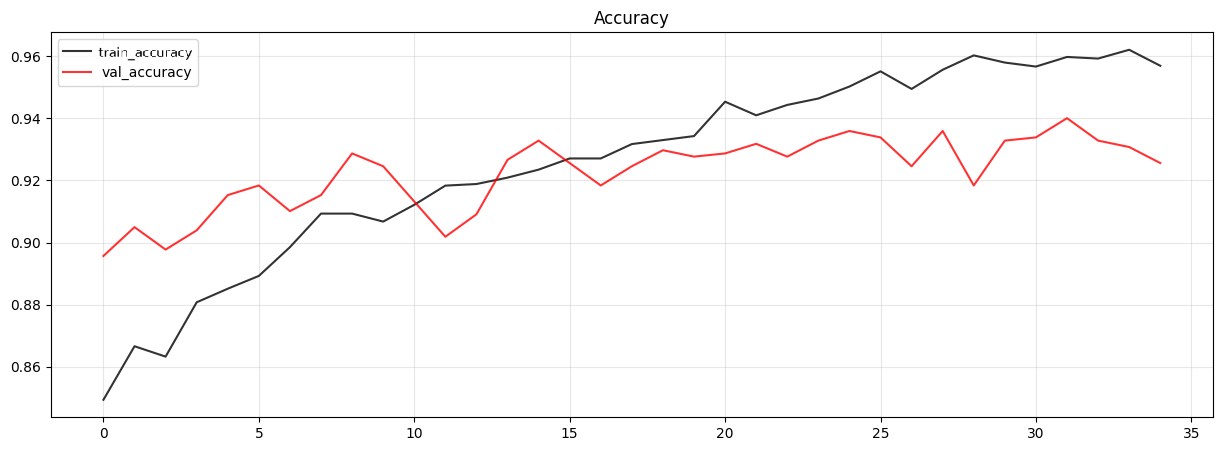

Now the situation is really improved than before, allowing us to have a pretty good model able to generalize.

Finally, in the hidden test, after have retrained it on training + validation sets we achieved:

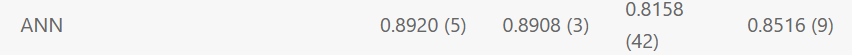